In [1]:
import json

# set the data subset to use
subset = 1
# load data
data = json.load(open('../data/subsets/visdial_1.0_train_'+ str(subset) +'percent_subset.json'))['data']
# load questions
questions = data['questions']
# load answers
answers = data['answers']
# load history: captions of images and the dialog rounds
dialogs = data['dialogs']

In [ ]:
'''Note: While doing the History Graph modeling,
Node 0 -> Caption
Node 1:11 -> Question-Answer rounds with Question-and-<Answered Answer> Pairs'''

# storing the history
history = []

for index in range(len(dialogs)):
    # storing the image caption
    caption = dialogs[index]['caption']
    # storing each of the dialog rounds
    q_and_a = []
    # for the dialog rounds
    for rounds in range(10):
        # question key and the question
        question_key = dialogs[index]['dialog'][rounds]['question']
        question = questions[question_key]
        # answer key and the selected answer
        answer_key = dialogs[index]['dialog'][rounds]['answer']
        answer = answers[answer_key]
        # append to q_and_a: note that the questions and answers have been separated by a "? " to mimic the GOG history features structure
        q_and_a.append("? ".join([question, answer]))
    # add the caption to the zero'th position for continuity (doesn't really matter since Graphs preserve the relational structure between the nodes)
    q_and_a.insert(0, caption)
    # append to history
    history.append(q_and_a)

# save the history structure for coreference resolution
with open('../embeddings/history/'+ str(subset) +'/history.json', 'w') as f:
    # indent=2 is not needed but makes the file human-readable
    # if the data is nested
    json.dump(history, f, indent=2)

In [2]:
import json

# set the data subset to use
subset = 1

'''Load the saved history structure'''
with open('../embeddings/history/'+ str(subset) +'/history.json', 'r') as f:
    history = json.load(f)

# example of a history entry
history[0]


['a sailboat-carrying truck with people in the back on a tree lined road',
 "are they pulled back? yes it's inside a phone case made to look like a plastic green shoe",
 "so he's out there with some other fellow surfers maybe? lettuce and carrot shreds",
 'are people walking on the platform? framed photo',
 'is the bridge for vehicles or for people to walk over? it is very clean',
 'is there any people around pizza? 8 or 9',
 'is there toilet paper on a roll? black top, white wheels',
 'where would you say this is if you had to guess? there is another blurry giraffe in the background',
 'what is the seat color? throwing frisbee',
 'are his socks pulled up to his knees? all i see is some hand soap',
 'is this professional or amateur photo? black top, white wheels']

In [4]:
import neuralcoref
import spacy

# Load the Spacy model and add neural coref to SpaCy's pipe
nlp = spacy.load('en')
neuralcoref.add_to_pipe(nlp)

'''Takes two strings and returns a boolean value indicating whether they are coreferent or not
    Method: Uses the neuralcoref library to compute the coref_scores for the document containing the two strings
            doc._.coref_scores is a dictionary with keys as the coreferent entities and a dict of all the coreferent entities and their scores as the values
            Get a list of all values in this dict_list that are positive:
                Return true if among these, doc._.coref_scores.keys() and doc._.coref_score entities are not in the same strings''' 

def is_coreferent(string1, string2):
    # get the document
    doc = nlp(string1 + " " + string2)
    # get the coref_scores
    coref_scores = doc._.coref_scores
    # get the list of all values in this dict_list that are positive
    for keys, values in coref_scores.items():
        for key, value in values.items():
            if value > 0:
                # check if the first element is from set 1 and third is from set 2 or vice versa
                if (keys.text in string1 and key.text in string2) or (keys.text in string2 and key.text in string1):
                    return True

# is_coreferent(history[0][0], history[0][1])
is_coreferent("My mother's name is Sanchita.", "She likes my home-cooked food.")

True

In [ ]:
'''Loop through all history entries and compute the edge list and the adj list for each history entry'''
from tqdm import tqdm

edge_list = [] # initialize the edge list for all history entries
for entry in tqdm(history):
    edge_list_entry = [] # initialize the edge list for each history entry
    compare_list = [entry[0]] # initialize the compare list for each history entry initialized with the caption
    for index in entry[1:]:
        for compare in compare_list:
            if is_coreferent(index, compare):
                # an edge between two nodes is indicated by both (0, 1) and (1, 0) since the graph is undirected
                edge_list_entry.append((entry.index(index), entry.index(compare))) 
                edge_list_entry.append((entry.index(compare), entry.index(index))) 
        compare_list.append(index)
    edge_list.append(edge_list_entry)


with open('../embeddings/history/'+ str(subset) +'/edge_list.json', 'w') as f:
    # indent=2 is not needed but makes the file human-readable
    # if the data is nested
    json.dump(edge_list, f)

adj_list = []
for element in tqdm(edge_list):
    # size here is 11 since there are always 11 nodes in each history entry
    size = 11
    # initialize adjacency list
    adj_list_element = [[0 for i in range(size)] for j in range(size)]
    # add edges to the adjacency list
    if len(element) != 0:
        for row, col in element:
            adj_list_element[row][col] = 1 # also an undirected edge since the edge list has both (0, 1) and (1, 0)
    # add the adjacency list to the list of adjacency matrices
    adj_list.append(adj_list_element)

with open('../embeddings/history/'+ str(subset) +'/adj_list.json', 'w') as f:
    # indent=2 is not needed but makes the file human-readable
    # if the data is nested
    json.dump(adj_list, f)

In [5]:
import json

# set the data subset to use
subset = 1

'''Displaying the first edge list'''
with open('../embeddings/history/'+ str(subset) +'/edge_list.json', 'r') as f:
    edge_list = json.load(f)

# example of an edge list entry
print(edge_list[0])

'''Displaying the first adjacency matrix'''
with open('../embeddings/history/'+ str(subset) +'/adj_list.json', 'r') as f:
    adj_list = json.load(f)

# example of an adjacency matrix entry
adj_list[0]

[[1, 0], [0, 1], [2, 1], [1, 2], [3, 1], [1, 3], [4, 0], [0, 4], [4, 1], [1, 4], [4, 2], [2, 4], [4, 3], [3, 4], [5, 1], [1, 5], [5, 4], [4, 5], [6, 1], [1, 6], [6, 4], [4, 6], [7, 2], [2, 7], [9, 1], [1, 9], [9, 2], [2, 9], [9, 4], [4, 9], [9, 7], [7, 9], [10, 1], [1, 10], [10, 4], [4, 10], [10, 6], [6, 10], [10, 7], [7, 10], [10, 9], [9, 10]]


[[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1],
 [0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0],
 [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1],
 [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1],
 [0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0]]

In [6]:
import pandas as pd

def load_glove_model(glove_file):
    readable_name = "-".join(glove_file.rstrip('.txt').split('/')[-1].split(".")).capitalize()
    print(f"Loading {readable_name} Model:")
    df = pd.read_csv(glove_file, sep=" ", quoting=3, header=None, index_col=0)
    glove_model = {key: val.values for key, val in df.T.items()}
    print(f"Done. {readable_name} with a vocabulary of {len(glove_model)} words was loaded!")
    return glove_model

glove_6b_300 = load_glove_model('../embeddings/glove/glove.6B.300d.txt')

Loading Glove-6b-300d Model:
Done. Glove-6b-300d with a vocabulary of 399998 words was loaded!


In [7]:
'''Tokenize a sentence using a glove model, pass it through an LSTm and return the last LSTM hidden state'''
from nltk.tokenize import RegexpTokenizer
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


def sentence_LSTM(glove_model, sentence):
    # tokenize the sentence
    tokenizer = RegexpTokenizer(r'\w+')  # to remove punctuations
    tokenized_sentence = tokenizer.tokenize(sentence.lower())

    # get the glove embedding for each word in the sentence
    glove_embeddings = []
    for word in tokenized_sentence:
        if word in glove_model.keys():
            glove_embeddings.append(glove_model[word])
        else:
            glove_embeddings.append(glove_model['unk'])

    # convert the glove embeddings to a numpy array
    glove_embeddings = np.array(glove_embeddings)
    # convert the glove embeddings to a tensor
    glove_embeddings = torch.tensor(glove_embeddings).float()

    # pass the glove embeddings through an LSTM
    # https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
    lstm = nn.LSTM(input_size=300, hidden_size=300,
                   num_layers=1, batch_first=True)
    lstm_out, (h_n, c_n) = lstm(
        glove_embeddings.view(1, len(tokenized_sentence), 300))

    # return the last hidden state
    return h_n.squeeze()

'''Testing LSTM hidden state output'''
sentence_LSTM(glove_6b_300, "What is the color of the shirt?").shape


torch.Size([300])

In [8]:
from tqdm import tqdm
import pickle

history_LSTM = []
'''Each entry in the History LSTM contains a list of the LSTM hidden state for each history node entry of a round of dialog'''
for entry in tqdm(history):
    history_LSTM.append(torch.tensor(np.array([sentence_LSTM(glove_6b_300, index).detach().numpy() for index in entry])))

# save the history_LSTM in a pickle file
with open('../embeddings/history/'+ str(subset) +'/history_LSTM.pkl', 'wb') as f:
    pickle.dump(history_LSTM, f)

100%|██████████| 1233/1233 [01:17<00:00, 15.99it/s]


In [9]:
history_LSTM[0].shape

torch.Size([11, 300])

In [1]:
import json
import pickle

# set the subset
subset = 1

'''Load the edge list'''
with open('../embeddings/history/'+ str(subset) +'/edge_list.json', 'r') as f:
    edge_list = json.load(f)

'''Load the adjacency matrix'''
with open('../embeddings/history/'+ str(subset) +'/adj_list.json', 'r') as f:
    adj_list = json.load(f)

'''Load the history_LSTM'''
with open('../embeddings/history/'+ str(subset) +'/history_LSTM.pkl', 'rb') as f:
    history_LSTM = pickle.load(f)

In [3]:
'''Intialize the graph with pytorch geometric'''
import torch
import numpy as np
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from tqdm import tqdm

'''Create a list of Data objects for each question where:
    - x is the history_LSTM
    Note: Each history_LSTM is a list of the LSTM hidden states for each history node entry of a round of dialog
    - edge_index is the edge list where they are contiguous'''

history_graphs = []
for i in tqdm(range(len(history_LSTM))):
    history_graphs.append(Data(x=torch.FloatTensor(np.array(history_LSTM[i])),
                        edge_index=torch.LongTensor(np.array(edge_list[i])).t().contiguous()))

'''Save the Data objects to a file'''
import pickle

with open('../embeddings/history/'+ str(subset) +'/history_graphs.pkl', 'wb') as f:
    pickle.dump(history_graphs, f)

100%|██████████| 1233/1233 [00:00<00:00, 13138.97it/s]


In [13]:
import pickle

# load the history_graphs
with open('../embeddings/history/'+ str(subset) +'/history_graphs.pkl', 'rb') as f:
    history_graphs = pickle.load(f)

history_graphs[0].view()

AttrView(store=Data(x=[11, 300], edge_index=[2, 42]), attr=DataTensorAttr(group_name=None, attr_name=<FieldStatus.UNSET: 1>, index=<FieldStatus.UNSET: 1>))

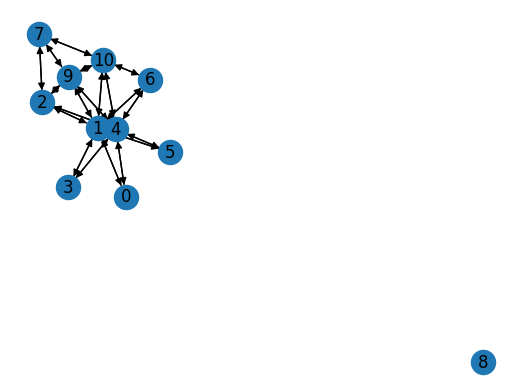

<Figure size 400x400 with 0 Axes>

In [6]:
'''Visualize the first history graph'''
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

# convert a pytorch geometric graph to a networkx graph
def visualize_graph(graph):
    G = to_networkx(graph)
    # initialize the figure and axes | Note: This somehow gets around the "TypeError: '_AxesStack' object is not callable"
    fig, ax = plt.subplots() 
    # draw the graph
    nx.draw(G, ax=ax, with_labels=True)
    # set the figure size 4x4
    plt.figure(figsize=(4, 4))

visualize_graph(history_graphs[0])

In [7]:
# Progress bar
from tqdm.notebook import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

# Torchvision
from torchvision import transforms
# PyTorch Lightning
import pytorch_lightning as pl


class GATLayer(nn.Module):

    def __init__(self, c_in, c_out, num_heads=1, concat_heads=True, alpha=0.2):
        """
        Inputs:
            c_in - Dimensionality of input features
            c_out - Dimensionality of output features
            num_heads - Number of heads, i.e. attention mechanisms to apply in parallel. The
                        output features are equally split up over the heads if concat_heads=True.
            concat_heads - If True, the output of the different heads is concatenated instead of averaged.
            alpha - Negative slope of the LeakyReLU activation.
        """
        super().__init__()
        self.num_heads = num_heads
        self.concat_heads = concat_heads
        if self.concat_heads:
            assert c_out % num_heads == 0, "Number of output features must be a multiple of the count of heads."
            c_out = c_out // num_heads

        # Sub-modules and parameters needed in the layer
        self.projection = nn.Linear(c_in, c_out * num_heads)
        self.a = nn.Parameter(torch.Tensor(
            num_heads, 2 * c_out))  # One per head
        self.leakyrelu = nn.LeakyReLU(alpha)

        # Initialization from the original implementation
        nn.init.xavier_uniform_(self.projection.weight.data, gain=1.414)
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

    def forward(self, node_feats, adj_matrix, print_attn_probs=False):
        """
        Inputs:
            node_feats - Input features of the node. Shape: [batch_size, c_in]
            adj_matrix - Adjacency matrix including self-connections. Shape: [batch_size, num_nodes, num_nodes]
            print_attn_probs - If True, the attention weights are printed during the forward pass (for debugging purposes)
        """
        batch_size, num_nodes = node_feats.size(0), node_feats.size(1)

        # Apply linear layer and sort nodes by head
        node_feats = self.projection(node_feats)
        node_feats = node_feats.view(batch_size, num_nodes, self.num_heads, -1)

        # We need to calculate the attention logits for every edge in the adjacency matrix
        # Doing this on all possible combinations of nodes is very expensive
        # => Create a tensor of [W*h_i||W*h_j] with i and j being the indices of all edges
        # Returns indices where the adjacency matrix is not 0 => edges
        edges = adj_matrix.nonzero(as_tuple=False)
        node_feats_flat = node_feats.view(
            batch_size * num_nodes, self.num_heads, -1)
        edge_indices_row = edges[:, 0] * num_nodes + edges[:, 1]
        edge_indices_col = edges[:, 0] * num_nodes + edges[:, 2]
        a_input = torch.cat([
            torch.index_select(input=node_feats_flat,
                               index=edge_indices_row, dim=0),
            torch.index_select(input=node_feats_flat,
                               index=edge_indices_col, dim=0)
        ], dim=-1)  # Index select returns a tensor with node_feats_flat being indexed at the desired positions along dim=0

        # Calculate attention MLP output (independent for each head)
        attn_logits = torch.einsum('bhc,hc->bh', a_input, self.a)
        attn_logits = self.leakyrelu(attn_logits)

        # Map list of attention values back into a matrix
        attn_matrix = attn_logits.new_zeros(
            adj_matrix.shape+(self.num_heads,)).fill_(-9e15)
        attn_matrix[adj_matrix[..., None].repeat(
            1, 1, 1, self.num_heads) == 1] = attn_logits.reshape(-1)

        # Weighted average of attention
        attn_probs = F.softmax(attn_matrix, dim=2)
        if print_attn_probs:
            print("Attention probs\n", attn_probs.permute(0, 3, 1, 2))
        node_feats = torch.einsum('bijh,bjhc->bihc', attn_probs, node_feats)

        # If heads should be concatenated, we can do this by reshaping. Otherwise, take mean
        if self.concat_heads:
            node_feats = node_feats.reshape(batch_size, num_nodes, -1)
        else:
            node_feats = node_feats.mean(dim=2)

        return node_feats

In [14]:
'''Initialize the GAT layer with:
- input dimension of 300 (the dimensionality of the node features)
- output dimension of 512 (the dimensionality of the output features)
- 4 attention heads
- attention heads are not concatenated
- alpha is set to 0.2
Note: The features here are set from the GoG Paper'''

gat_layer = GATLayer(c_in=300, c_out=512, num_heads=4, concat_heads=False, alpha=0.2)
# print(history_graphs[0].x.shape)
# print(torch.tensor(adj_list[0]).shape)

# testing the GAT layer with the first history graph
with torch.no_grad():    
    # note that we have to unsqueeze the node features to fit the GAT input shape
    out_feats = gat_layer(history_graphs[0].x.unsqueeze(0), torch.tensor([adj_list[0]]), print_attn_probs=False)
    
print(history_graphs[0].x.squeeze().shape)
print(out_feats.squeeze().shape)


torch.Size([11, 300])
torch.Size([11, 512])


In [15]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from tqdm import tqdm

'''Do this for all History Graphs and save it to the History Graph Attention List'''
history_gat = history_graphs.copy()
for i in tqdm(range(len(history_graphs))):
    with torch.no_grad():
        out = gat_layer(history_graphs[i].x.unsqueeze(0), torch.tensor([adj_list[i]]), print_attn_probs=False)
    history_gat[i].x = out.squeeze()

'''Save the History Graph Attention List to a pickle file in the proper directory'''
with open('../embeddings/history/'+ str(subset) +'/history_GAT.pkl', 'wb') as f:
    pickle.dump(history_gat, f)

100%|██████████| 1233/1233 [00:00<00:00, 1363.74it/s]


In [63]:
import dgl
from dgl.nn import GlobalAttentionPooling

# initialize the gate layer
gate_nn = torch.nn.Linear(512, 1)
# initialize the GlobalAttentionPooling layer
gap = GlobalAttentionPooling(gate_nn)

'''For each history graph, we need to convert it to a DGL graph and then apply the GlobalAttentionPooling layer'''
history_GAP = []

for i in tqdm(range(len(history_gat))):
    # initialize an empty dgl graph containing 11 nodes
    g = dgl.graph(([], []), num_nodes=history_gat[i].num_nodes)
    # initialize the node features for the dgl graph where each node has 512 features
    g_node_feats = history_gat[i].x
    # add the edges to the dgl graph where edges are the edges from the pytorch geometric graph
    g.add_edges(history_gat[i].edge_index[0], history_gat[i].edge_index[1])
    # apply the GlobalAttentionPooling layer to the dgl graph
    out = gap(g, g_node_feats)
    # append the output to the history_GAP list
    history_GAP.append(out.squeeze())

'''Save the History Graph Attention Pooling List to a pickle file in the proper directory'''
with open('../embeddings/history/'+ str(subset) +'/history_GAP.pkl', 'wb') as f:
    pickle.dump(history_GAP, f)

100%|██████████| 1233/1233 [00:01<00:00, 861.13it/s]


In [65]:
'''Create a DataLoader object to load the Data objects in batches'''
history_loader = DataLoader(history_gat, batch_size=32, shuffle=False)

with open('../embeddings/history/' + str(subset) + '/history_loader.pkl', 'wb') as f:
    pickle.dump(history_loader, f)


In [ ]:
'''Also implement the case where there's an edge_attr which is the coreference score'''

In [23]:
'''AllenNLP Coreference Resolution'''
from allennlp.predictors.predictor import Predictor

'''download the model'''
predictor = Predictor.from_path(
    "https://storage.googleapis.com/allennlp-public-models/coref-spanbert-large-2021.03.10.tar.gz")


/bigpool/homes/chatterjee/anaconda3/envs/e2ecoref/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /bigpool/homes/chatterjee/anaconda3/envs/e2ecoref/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


/bigpool/homes/chatterjee/anaconda3/envs/e2ecoref/lib/python3.7/site-packages/rich/live.py:229: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Output()

Downloading: 100%|██████████| 414/414 [00:00<00:00, 163kB/s]
Downloading: 100%|██████████| 208k/208k [00:00<00:00, 506kB/s]  
Downloading: 100%|██████████| 634M/634M [00:12<00:00, 53.8MB/s] 
Some weights of BertModel were not initialized from the model checkpoint at SpanBERT/spanbert-large-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
'''AllenNLP Coreference Resolution:
    Method: Input two sentences and return true or false if they have a coreference using the AllenNLP coreference model'''

def coref(text1, text2):
    text = text1 + ' ' + text2
    prediction = predictor.predict(document=text)
    # find corresponding strings from the text and create a cluster entity list
    entity_clusters = []
    for entity in prediction['clusters']:
        entity_cluster = []
        for entry in entity:
            entity_cluster.append(' '.join(text.split()[entry[0]:entry[1]+1]))
        # remove empty strings
        entity_cluster = [entry for entry in entity_cluster if entry != '']
        entity_clusters.append(entity_cluster)

    # if all the entities in a cluster are in the same sentence, then return False (no coreference)
    for entity_cluster in entity_clusters:
        which_sentence = []
        for entity in entity_cluster:
            if entity in text1 and entity not in text2:
                which_sentence.append(1)
            elif entity in text2 and entity not in text1:
                which_sentence.append(2)
        if len(set(which_sentence)) == 1:
            return False
    # if all the entities in a cluster are in different sentences, then return True (coreference)
    return True


coref('This is a picture of a horse and a man standing by a stack of crates.',
      'Is the horse brown? Yes, it is.')

True

In [ ]:
'''Implementation of the e2e-coref model'''
